In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
import nltk
import multiprocessing
import pickle
import os
from wordcloud import WordCloud

C:\Users\310228580\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [13]:
# Loading all the text after taking off the stop words
def read_text(filepath):
    def tokenize(text):
        word_num = 0
        sentences = []
        for sent in nltk.sent_tokenize(text, language='english'):
            tokens = []
            custom_stop_words = ['he','thee', 'also', 'said', 'unto', 
                                 'thou', 'hast', 'us', 'therefore', 'hath',
                                 'saith', 'stephen', 'doings','ye', 'verily', 
                                 'may', 'will', 'us', 'said', 'say', 'elif', 
                                 'shall', 'speaketh', 'doers', 'thus', 'look', 'well',"'t" ]
            for word in nltk.word_tokenize(sent, language='english'):
                if len(word) < 2 or word.lower() in nltk.corpus.stopwords.words('english') or word.lower() in custom_stop_words:
                    continue
                tokens.append(word.lower())
            if tokens: 
                sentences.append(tokens)
                word_num += len(tokens)
        return sentences, word_num
    
    sentences = []
    with open(filepath,encoding = 'utf-8-sig') as inp:
        text, word_num = tokenize(inp.read())#.replace("\n", " ").replace("\t", " ").replace(". ", ".")
        print("# words:", word_num)
        return text

In [14]:
text_koran = read_text("books//Koran.txt")
text_medit = read_text("books//Meditations.txt")
text_buddha = read_text("books//Gospel of Buddha.txt")
text_king = read_text("books//King James Bible.txt")
text_gita = read_text("books//Gita.txt")
text_mahabharata = read_text("books//Mahabharata.txt")

# words: 83063
# words: 28903
# words: 123750
# words: 43759
# words: 358755
# words: 11246
# words: 308583


#### Pickling the files for easy access

In [15]:
corpus = {'koran':text_koran,'meditation':text_medit,'buddha':text_buddha, 'bible':text_king,
          'gita':text_gita, 'mahabharata':text_mahabharata}

In [16]:
#Writing to pickle
for key in corpus.keys():
    with open(r"pickle//{}.pickle".format(key), "wb") as output_file:
        pickle.dump(corpus[key],output_file)

In [5]:
#Loading from pickle
corpus = {'koran':None,'meditation':None,'buddha':None, 'bible':None,
          'gita':None, 'mahabharata':None}
for key in corpus.keys():
    with open(r"{}.pickle".format(key), "rb") as input_file:
        corpus[key] = pickle.load(input_file)

#### Word2Vec Models

In [17]:
n_iterations = 300
n_workers = multiprocessing.cpu_count()
n_dim = 100

w2v_medit =   gensim.models.Word2Vec(text_medit, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_medit.save('w2v models//meditation_model.sav')
w2v_morm =     gensim.models.Word2Vec(text_morm, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_morm.save('mormon_model.sav')
w2v_koran =   gensim.models.Word2Vec(text_koran, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_koran.save('w2v models//koran_model.sav')
w2v_buddha = gensim.models.Word2Vec(text_buddha, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_buddha.save('w2v models//buddha_model.sav')
w2v_king =     gensim.models.Word2Vec(text_king, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_king.save('w2v models//bible_model.sav')
w2v_gita =     gensim.models.Word2Vec(text_gita, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_gita.save('w2v models//gita_model.sav')
w2v_mahabharata = gensim.models.Word2Vec(text_mahabharata, size=n_dim, sg=1, iter=n_iterations, workers=n_workers)
w2v_mahabharata.save('w2v models//mahabharata_model.sav')


In [3]:
#Reading saved models
w2v_medit = gensim.models.Word2Vec.load('w2v models//meditation_model.sav') 
w2v_koran = gensim.models.Word2Vec.load('w2v models//koran_model.sav')
w2v_buddha = gensim.models.Word2Vec.load('w2v models//buddha_model.sav')
w2v_king = gensim.models.Word2Vec.load('w2v models//bible_model.sav')
w2v_gita = gensim.models.Word2Vec.load('w2v models//gita_model.sav')
w2v_mahabharata = gensim.models.Word2Vec.load('w2v models//mahabharata_model.sav')

#### Word Clouds

In [18]:
def generate_wordcloud_from_text(text, bg_color='white', cmap="RdPu", fig_size=(10,10)):
    _, ext = os.path.splitext(text)
    if ext == '.':
        #text passed
        wordcloud = WordCloud().generate(text)
    else:
        #filename passed
        with open(text,encoding = 'utf-8-sig') as inp:
            wordcloud = WordCloud(background_color=bg_color,colormap=cmap).generate(inp.read())
    plt.figure(figsize=fig_size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

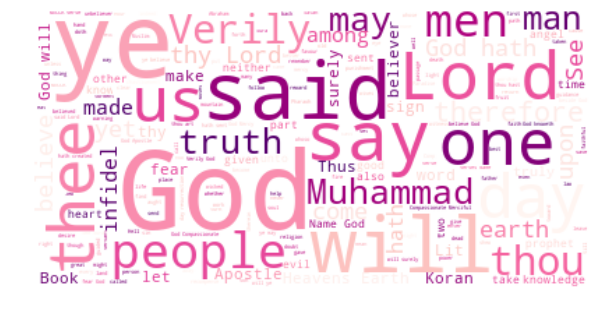

In [49]:
generate_wordcloud_from_text('Koran.txt')

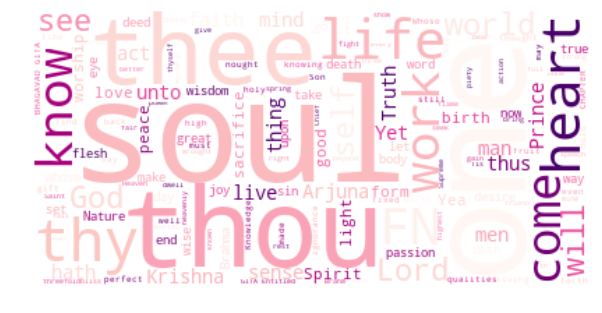

In [8]:
generate_wordcloud_from_text('Gita.txt')

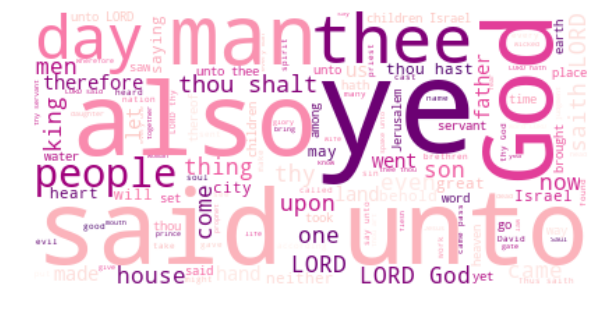

In [10]:
generate_wordcloud_from_text('King James Bible.txt')

#### WordClouds from Similar Words - Word2vec

In [4]:
def most_similar(pos_word, neg_word = []):
    
    def _generate_word_cloud(similar_words):
        dict_words = {}
        for w in similar_words:
            dict_words[w[0]]=w[1]
        wordcloud=WordCloud(background_color="white",colormap="magma").generate_from_frequencies(dict_words)
        return wordcloud
            
    def _most_sim(w2v, pos_word, neg_word, text):    
        try:    
            return _generate_word_cloud(w2v.most_similar(pos_word, neg_word))
        except KeyError:
            print("Words ", pos_word, neg_word, "not in the text ", text, "\n")
            return None
    def _plot(wordcloud, ax, text):
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(text,fontsize=18)
            
#     _most_sim(w2v_medit, pos_word, neg_word, "Meditations")
    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 20 
    fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(figsize=(10,10),nrows=3, ncols=2)
    fig.suptitle("Most Similar Words - {}".format(pos_word.title()),fontsize=24, color='purple')
    text_vecs = {'Bible':w2v_king,'Koran':w2v_koran,'Gita':w2v_gita,
                 'Buddha':w2v_buddha,'Mahabharat':w2v_mahabharata,'Mormon':w2v_morm}
    axes = [ax1,ax2,ax3,ax4,ax5,ax6]
    i=0
    for key in text_vecs.keys():
        wordcloud = _most_sim(text_vecs[key], pos_word, neg_word, key)
#         print (wordcloud.words_)
        _plot(wordcloud, axes[i], key)
        i+=1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

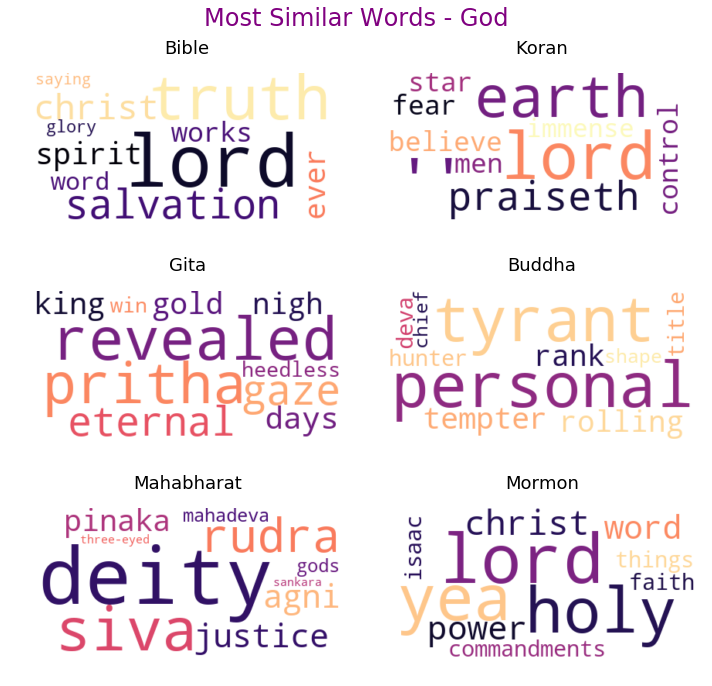

In [22]:
most_similar('god')

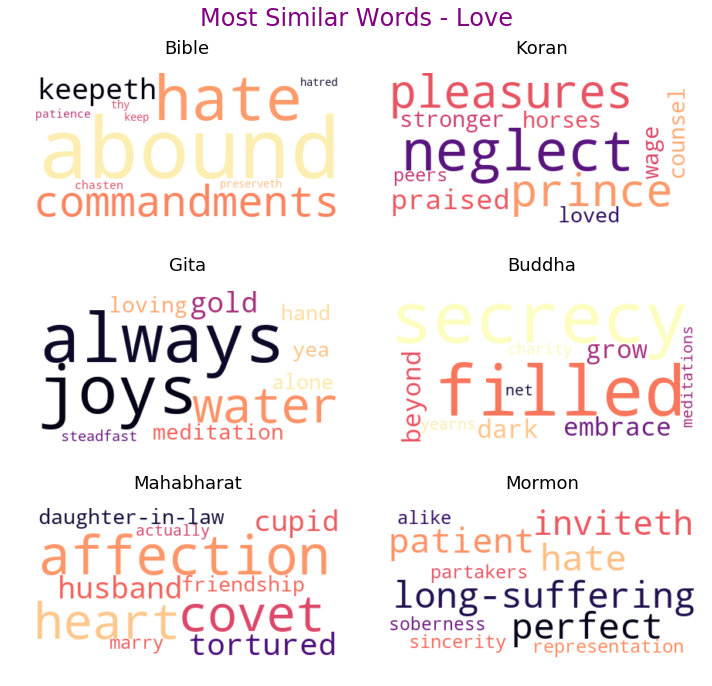

In [23]:
most_similar('love')

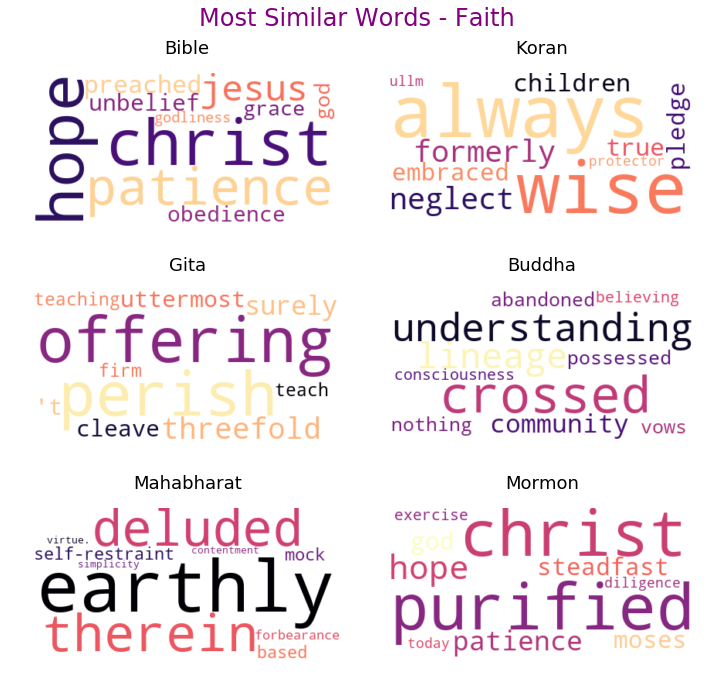

In [24]:
most_similar('faith')

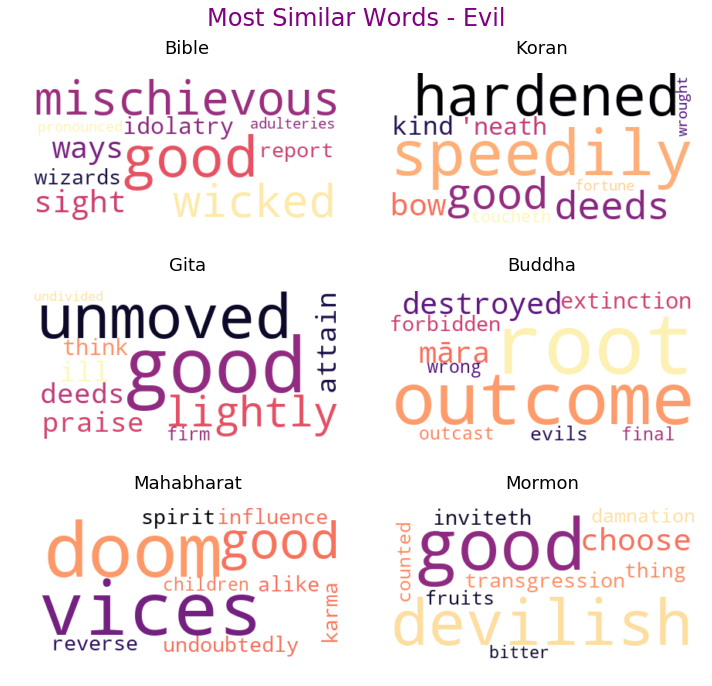

In [25]:
most_similar('evil')

#### Word Association Network - FlexDashboard

In [2]:
def generate_word_assoc_tree(w2v, name, seed, max_words=5):
    if seed in w2v.wv.vocab:
        level_1 = w2v.most_similar(seed,topn=max_words)
        node_cols = ['id','word','level','level_label','word_count','book','seed']
        node_df = pd.DataFrame(columns= node_cols)
        link_cols = ['from','to','similarity','book','seed']
        link_df = pd.DataFrame(columns=link_cols)
        node_ix=0
        link_ix=1
        node_df.loc[node_ix,'id'] = node_ix
        node_df.loc[node_ix,'word'] = seed
        node_df.loc[node_ix,'level'] = 0
        node_df.loc[node_ix,'level_label'] = "Level {}".format(0)
        node_df.loc[node_ix,'word_count'] = w2v.wv.vocab[seed].count
        parent_node = 0
        node_ix+=1
        for word in level_1:
            node_df.loc[node_ix,'id'] = node_ix
            node_df.loc[node_ix,'word'] = word[0]
            node_df.loc[node_ix,'level'] = 1
            node_df.loc[node_ix,'level_label'] = "Level {}".format(1)
            node_df.loc[node_ix,'word_count'] = w2v.wv.vocab[word[0]].count
            link_df.loc[link_ix,'from'] = parent_node
            link_df.loc[link_ix,'to'] = node_ix
            link_df.loc[link_ix,'similarity'] = word[1]
            parent_node2 = int(node_ix)
            node_ix+=1
            link_ix+=1
            if word[0] in w2v.wv.vocab:
                level_2 = w2v.most_similar(word[0],topn=5)
            else:
                level_2 = []
            for word in level_2:
                if word[0] in node_df.word.values:
        #             print (word[0])
        #             print (parent_node2)

                    node_id = node_df.loc[node_df.word == word[0],'id'].values[0]
        #             print (node_id)
                    link_df.loc[link_ix,'from'] = parent_node2
                    link_df.loc[link_ix,'to'] = node_id
                    link_df.loc[link_ix,'similarity'] = word[1]
                else:
                    node_df.loc[node_ix,'id'] = node_ix
                    node_df.loc[node_ix,'word'] = word[0]
                    node_df.loc[node_ix,'level'] = 2
                    node_df.loc[node_ix,'level_label'] = "Level {}".format(2)
                    if word in w2v.wv.vocab:
                        node_df.loc[node_ix,'word_count'] = w2v.wv.vocab[word[0]].count
                    else:
                        node_df.loc[node_ix,'word_count'] = 0
                    link_df.loc[link_ix,'from'] = parent_node2
                    link_df.loc[link_ix,'to'] = node_ix
                    link_df.loc[link_ix,'similarity'] = word[1]
                node_ix+=1
                link_ix+=1
    else:
        node_df = pd.DataFrame()
        link_df = pd.DataFrame()
    node_df['seed'] = seed
    link_df['seed'] = seed
    node_df['book'] = name
    link_df['book'] = name
    return node_df, link_df

In [6]:
word2vec_list = [w2v_buddha,w2v_gita,w2v_king,w2v_koran,w2v_mahabharata,w2v_medit]
name_list = ['Gospel of Buddha','Gita', 'King James Bible','Quran','Mahabharata','Meditation']

In [3]:
seed_words = ['god','love','faith','evil','money','hell','heaven','salvation','hate']

In [8]:
node_df_list = []
link_df_list = []
for seed_word in seed_words:
#     print (seed_word)
    for i,w2v in enumerate(word2vec_list):
#         print (name_list[i])
        node_df, link_df = generate_word_assoc_tree(w2v,name=name_list[i],seed=seed_word)
        node_df_list.append(node_df)
        link_df_list.append(link_df)

In [9]:
## Saving to csv for use in Flexdashboard
pd.concat(node_df_list, ignore_index=True).to_csv('output//node.csv')
pd.concat(link_df_list, ignore_index=True).to_csv('output//link.csv')

#### Sentiment Analysis

In [2]:
def load_NRC_emotion_lexicon(filename=None):
    if filename is None:
        filename = 'lexicons//NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt'
    #Reading NRC Lexicon
    wordList = defaultdict(list)
    emotionList = defaultdict(list)
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
    #     headerRows = [i for i in range(0, 46)]
    #     for row in headerRows:
    #         next(reader)
        for word, emotion, present in reader:
            if int(present) == 1:
                #print(word)
                wordList[word].append(emotion)
                emotionList[emotion].append(word)
    return wordList, emotionList

In [3]:
#Chapterize is custom python module wich parses these files
from collections import OrderedDict, defaultdict, Counter
import csv
from Chapterize import Book
import os
def generate_emotion_count(text, normalize = True):

    def count_emotions(text,tokenizer):
        emoCount = Counter()
        tokens = tokenizer(text,language='english')
        for token in tokens:
            emoCount += Counter(wordList[token.lower()])
        return emoCount, len(tokens)

    _, ext = os.path.splitext(text)
    
    if ext != '.':
        book = Book(filename = text)
    else:
        book = Book(contents = text)
    wordList, emotionList = load_NRC_emotion_lexicon()
    emotionCounts = [count_emotions("".join(ch),nltk.word_tokenize) for ch in book.chapters]
    emotions, words = zip(*emotionCounts)
    emotion_df = pd.DataFrame(list(emotions))
    emotion_df = emotion_df.fillna(0)
    emotion_df['word_counts'] = pd.Series(words)
    emotion_df['chapter_names'] = pd.Series(book.heading_names)
    if normalize:
        emotion_df = emotion_df.drop('word_counts', axis = 1).divide(emotion_df["word_counts"], axis='index')
    return emotion_df

In [4]:
files=["Koran.txt","Meditations.txt","Gospel of Buddha.txt","King James Bible.txt","Gita.txt","Mahabharata.txt"]

In [5]:
all_df=pd.DataFrame()
for text in files:
    d=generate_emotion_count(text, normalize=False).reset_index().rename(columns={'index':'chapter'})
    name, ext = os.path.splitext(text)
    d['file'] = name
    d['chapter']+=1
    all_df = pd.concat([all_df, d], ignore_index=True)
    

In [6]:
all_df.head()

,chapter,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_counts,chapter_names,file
0,1,16.0,23,8.0,28.0,14.0,34.0,39,14.0,9.0,37,1137,SURA LXXIV.-THE ENWRAPPED1 [II.],Koran
1,2,6.0,19,5.0,13.0,13.0,13.0,36,5.0,4.0,27,752,SURA LXXIII. THE ENFOLDED1 [III.],Koran
2,3,1.0,6,3.0,4.0,8.0,9.0,18,3.0,0.0,14,316,SURA XCIII.1-THE BRIGHTNESS [IV.],Koran
3,4,1.0,4,1.0,2.0,3.0,2.0,6,2.0,2.0,4,72,SURA XCIV.-THE OPENING [V.],Koran
4,5,0.0,1,2.0,1.0,1.0,5.0,5,0.0,0.0,3,127,SURA CXIII.-THE DAYBREAK [VI.],Koran


In [7]:
#writig to csv for use in Flexdashboard
all_df.to_csv('output//emotion_count.csv', index=None)